# Imports and preliminary

In [42]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
from google.colab import drive
from google.colab import files

import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics 

from sklearn import linear_model # for linear regression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split #train_test_split function

from sklearn.metrics import accuracy_score

from scipy import interpolate
import numpy as np


In [2]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/house-prices-advanced-regression-techniques

Mounted at /content/gdrive
/content/gdrive/My Drive/house-prices-advanced-regression-techniques


In [3]:
#Load the data
dfRaw = pd.read_csv("train.csv", index_col="Id")
#I like to keep dfRaw as unmodified version of original csv

#Pre-processing

In [4]:
dfPre = dfRaw.copy(deep=True)


#Replace the N/A values that mean "zero" or "no" with the appropriate value
dfPre["BsmtCond"] = dfPre["BsmtCond"].fillna("No")
dfPre["GarageFinish"] = dfPre["GarageFinish"].fillna("No")
dfPre["GarageCond"] = dfPre["GarageCond"].fillna("No")
dfPre["Fence"] = dfPre["Fence"].fillna("No")
dfPre["MiscFeature"] = dfPre["MiscFeature"].fillna("No")
dfPre["BsmtExposure"] = dfPre["BsmtExposure"].fillna("No")
dfPre["BsmtQual"] = dfPre["BsmtQual"].fillna("No")
dfPre["Alley"] = dfPre["Alley"].fillna("No")
dfPre["PoolQC"] = dfPre["PoolQC"].fillna("No")
dfPre["GarageQual"] = dfPre["GarageQual"].fillna("No")
dfPre["BsmtFinType2"] = dfPre["BsmtFinType2"].fillna("No")
dfPre["BsmtFinType1"] = dfPre["BsmtFinType1"].fillna("No")
dfPre["FireplaceQu"] = dfPre["FireplaceQu"].fillna("No")
dfPre["LotFrontage"] = dfPre["LotFrontage"].fillna(0)
dfPre["GarageType"] = dfPre["GarageType"].fillna("No")


#Replace remaining NA with column average
dfPre = dfPre.fillna(dfRaw.mean())

#One hot encoding for converting string data into numeric
dfPre = pd.get_dummies(dfPre)

#Standardize everything
colnames=dfPre.columns
dfPre = StandardScaler().fit_transform(dfPre)
dfPre=pd.DataFrame(dfPre, columns=colnames)



#Model - Simple Regression

NO PCA

In [5]:
#Split up the x and y values
X = dfPre.drop(columns = ['SalePrice']) #need to drop the target from the data points
y = dfPre['SalePrice'] #save the target values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10, test_size=0.2) #80:20 test train split

regr = linear_model.LinearRegression()
startT = time.time()
regr.fit(X_train, y_train)
print("TIME:", time.time()-startT)
yPred = regr.predict(X_test)
errorTest = round(mean_squared_error(y_test,yPred),2)
print(errorTest)

yPred = regr.predict(X_train)
errorInSample = round(mean_squared_error(y_train,yPred),2)
print(errorInSample)

#As you can see, good in sample error, horrible out of sample error. This means overfitting is occuring

TIME: 0.0972452163696289
4.622414272043695e+25
0.06


PCA

In [6]:
#Split up the x and y values
X = dfPre.drop(columns = ['SalePrice']) #need to drop the target from the data points
y = dfPre['SalePrice'] #save the target values

numComponents = 185
pca = PCA(n_components=numComponents)
principalComponents = pca.fit_transform(X)

colLabels = []
for i in range(numComponents):
  colLabels.append("pca"+str(i))
df_trans = pd.DataFrame(data = principalComponents, columns=colLabels)

X_train, X_test, y_train, y_test = train_test_split(df_trans,y, random_state = 10, test_size=0.2) #80:20 test train split

regr = linear_model.LinearRegression()
startT = time.time()
regr.fit(X_train, y_train)
print("TIME:", time.time()-startT)
yPred = regr.predict(X_test)
errorTest = round(mean_squared_error(y_test,yPred),2)
print(errorTest)

yPred = regr.predict(X_train)
errorInSample = round(mean_squared_error(y_train,yPred),2)
print(errorInSample)

TIME: 0.05643296241760254
0.86
0.09


#Model - Lasso Regression



I first pick a random alpha = .01. 
This works well, but I can compute a superior alpha

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10, test_size=0.2) #80:20 test train split

regr = linear_model.Lasso(alpha=.01)
startT = time.time()
regr.fit(X_train, y_train)
print("TIME:", time.time()-startT)
yPred = regr.predict(X_test)
errorTest = round(mean_squared_error(y_test,yPred),2)
print(errorTest)

yPred = regr.predict(X_train)
errorInSample = round(mean_squared_error(y_train,yPred),2)
print(errorInSample)

#Regularized yields a slightly worse in sample error, but an immensley better out of sample error

TIME: 0.058380126953125
0.09
0.08


Cross Validation to select Alpha

In [8]:
X = dfPre.drop(columns = ['SalePrice']) #need to drop the target from the data points
y = dfPre['SalePrice'] #save the target values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10, test_size=0.2) #80:20 test train split


regr = linear_model.LassoCV(cv=10)
startT = time.time()
regr.fit(X_train, y_train)
print("TIME:", time.time()-startT)
print("Best Alpha", regr.alpha_)

yPred = regr.predict(X_test)
errorTest = round(mean_squared_error(y_test,yPred),2)
print(errorTest)

yPred = regr.predict(X_train)
errorInSample = round(mean_squared_error(y_train,yPred),2)
print(errorInSample)


TIME: 1.829061508178711
Best Alpha 0.018101156993507592
0.1
0.09


#Model - KNN

0        (-0.226, 0.417]
1        (-0.226, 0.417]
2         (0.417, 7.229]
3       (-0.642, -0.226]
4         (0.417, 7.229]
              ...       
1455     (-0.226, 0.417]
1456     (-0.226, 0.417]
1457      (0.417, 7.229]
1458    (-0.642, -0.226]
1459    (-0.642, -0.226]
Name: SalePrice, Length: 1460, dtype: category
Categories (4, interval[float64]): [(-1.8399999999999999, -0.642] < (-0.642, -0.226] < (-0.226, 0.417] <
                                    (0.417, 7.229]]
N= 1
0.589041095890411
1.0


N= 2
0.5513698630136986
0.815068493150685


N= 3
0.613013698630137
0.8133561643835616


N= 4
0.6095890410958904
0.764554794520548




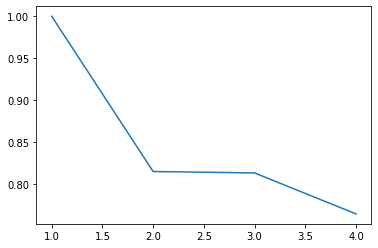

In [9]:
#What if we just forget about a continous output, and discreetize it into different bins. This still has utility in the context of the problem.

#Split up the x and y values
X = dfPre.drop(columns = ['SalePrice']) #need to drop the target from the data points
y = dfPre['SalePrice'] #save the target values

#Discreetizing
binRanges = pd.qcut(y, q=4)
y = binRanges
print(y)
'''
y = 1*round(y/1)
print(y)
'''

y = y.astype(str) #so its recognized as a non-continous type
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10, test_size=0.2) #80:20 test train split

scores = []
for n in range(1,5):
  print("N=",n)
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  y_pred_knn = knn.predict(X_test)
  accuracyOutSample = accuracy_score(y_test, y_pred_knn)
  print(accuracyOutSample)

  y_pred_knn = knn.predict(X_train)
  accuracyInSample = accuracy_score(y_train, y_pred_knn)
  print(accuracyInSample)
  scores.append(accuracyInSample)
  print("")
  print("")

sns.lineplot(x=range(1,5), y=scores)



#PERFORMANCE OF LASSO

Different splits

Text(0, 0.5, 'MSE')

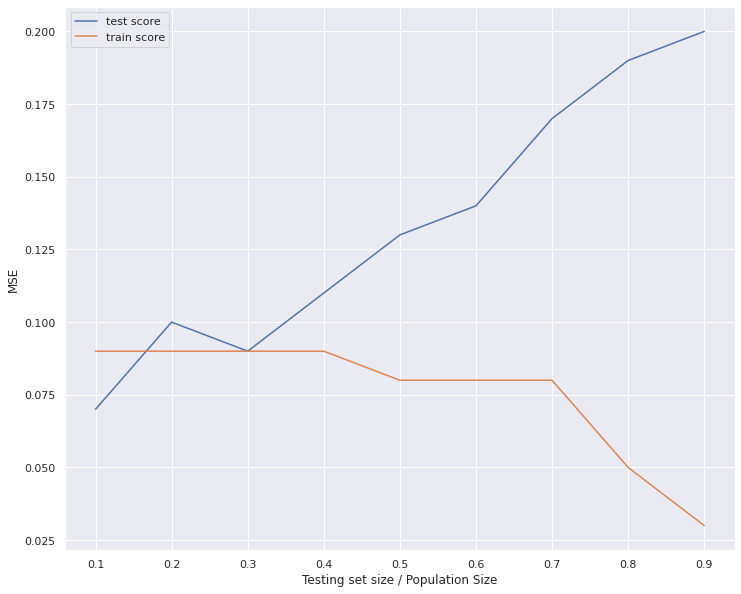

In [10]:
#Split up the x and y values
X = dfPre.drop(columns = ['SalePrice']) #need to drop the target from the data points
y = dfPre['SalePrice'] #save the target values

scores1 = []
scores2 = []
testSizes = [i/10 for i in range(1,10)]
for testSize in testSizes:
  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10, test_size=testSize) #dynamic

  regr = linear_model.Lasso(alpha=.018)
  regr.fit(X_train, y_train)
  yPred = regr.predict(X_test)
  errorTest = round(mean_squared_error(y_test,yPred),2)

  yPred = regr.predict(X_train)
  errorInSample = round(mean_squared_error(y_train,yPred),2)

  scores1.append(errorTest)
  scores2.append(errorInSample)


sns.set(rc={'figure.figsize':(12,10)})
sns.lineplot(x=testSizes, y=scores1, legend='brief', label="test score")
sns.lineplot(x=testSizes, y=scores2, legend='brief', label="train score")
plt.xlabel("Testing set size / Population Size")
plt.ylabel("MSE")


different random states

Text(0.5, 0, 'MSE')

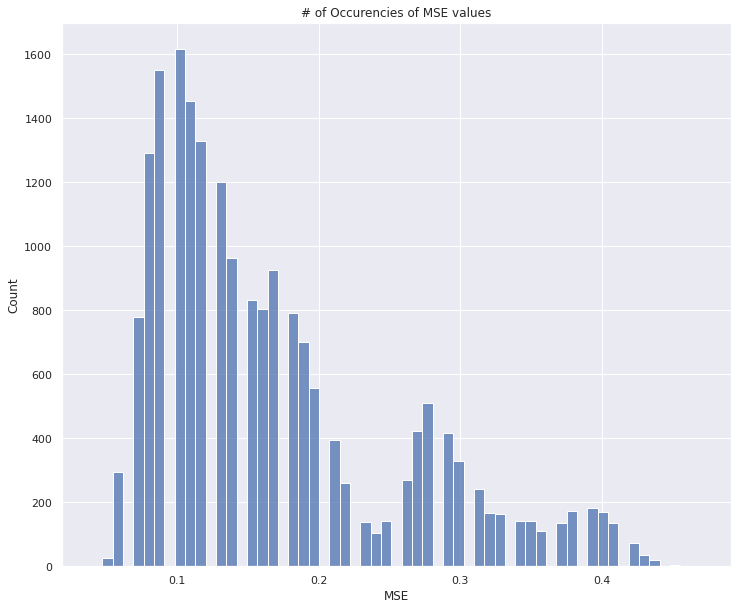

In [11]:
#Split up the x and y values
X = dfPre.drop(columns = ['SalePrice']) #need to drop the target from the data points
y = dfPre['SalePrice'] #save the target values

# What happenens if i try different random states
scores1 = []
scores2 = []
regr = linear_model.Lasso(alpha=.018)
for testSize in range(0,20000):
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

  regr.fit(X_train, y_train)
  yPred = regr.predict(X_test)
  errorTest = round(mean_squared_error(y_test,yPred),2)

  #yPred = regr.predict(X_train)
  #errorInSample = round(mean_squared_error(y_train,yPred),2)

  scores1.append(errorTest)
  #scores2.append(errorInSample)

plt.figure()
sns.histplot(data=scores1).set_title("# of Occurencies of MSE values")
plt.xlabel("MSE")


removing attributes

BsmtFinType2_GLQ     0.000076
RoofMatl_Metal      -0.000304
RoofStyle_Mansard   -0.000308
GarageCond_Gd       -0.000983
Foundation_Wood      0.002711
                       ...   
GarageArea           0.623431
GarageCars           0.640409
GrLivArea            0.708624
OverallQual          0.790982
SalePrice            1.000000
Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0, 0.5, 'MSE')

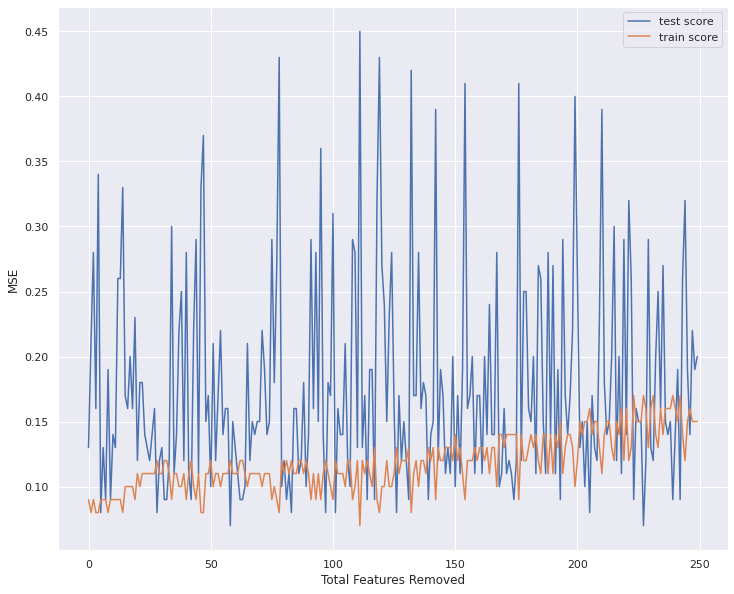

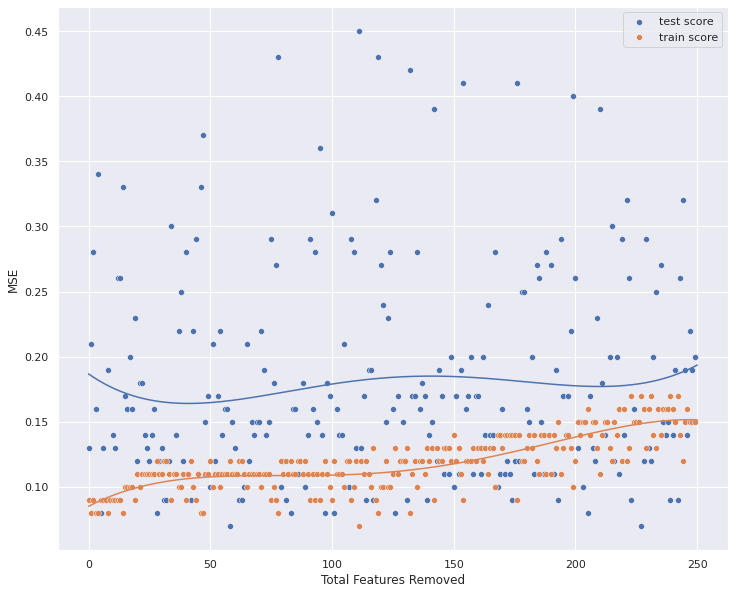

In [89]:
#most correlated variables (ignoring sign)
dfDrop = dfPre.copy(deep=True)
corrs = dfDrop.corr().astype(float)
s = corrs.unstack()
sorted = s.sort_values(key=abs)
print(sorted["SalePrice"]) #this is what I need


indexNames = sorted["SalePrice"].index.values.tolist()



# loop through removing more and more features
scores1 = []
scores2 = []
regr = linear_model.Lasso(alpha=.018)
totalRemoved = 250
for numFeaturesRemoved in range(0,totalRemoved):

  #print("numFeaturesRemoved", numFeaturesRemoved)
  X = dfDrop.drop(columns = indexNames[0:numFeaturesRemoved])
  X = X.drop(columns = ['SalePrice']) #need to drop the target from the data points
  y = dfDrop['SalePrice'] #save the target values 
  
  #print(len(X.columns))
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

  regr.fit(X_train, y_train)
  yPred = regr.predict(X_test)
  errorTest = round(mean_squared_error(y_test,yPred),2)

  yPred = regr.predict(X_train)
  errorInSample = round(mean_squared_error(y_train,yPred),2)

  scores1.append(errorTest)
  scores2.append(errorInSample)


sns.set(rc={'figure.figsize':(12,10)})
sns.lineplot(x=range(0,totalRemoved), y=scores1, legend='brief', label="test score")
sns.lineplot(x=range(0,totalRemoved), y=scores2, legend='brief', label="train score")
plt.xlabel("Total Features Removed")
plt.ylabel("MSE")

plt.figure()


# use bc_type = 'natural' adds the constraints as we described above
f = interpolate.UnivariateSpline(range(0,totalRemoved), scores1, k = 4, s = 3)
xNew = np.linspace(0, totalRemoved, 10000)
yNew = f(xNew)
sns.lineplot(xNew,yNew)

f = interpolate.UnivariateSpline(range(0,totalRemoved), scores2, k = 4, s = 3)
xNew = np.linspace(0, totalRemoved, 10000)
yNew = f(xNew)
sns.lineplot(xNew,yNew)

sns.scatterplot(range(0,totalRemoved), scores1, label="test score")
sns.scatterplot(range(0,totalRemoved), scores2, label="train score")
plt.xlabel("Total Features Removed")
plt.ylabel("MSE")


